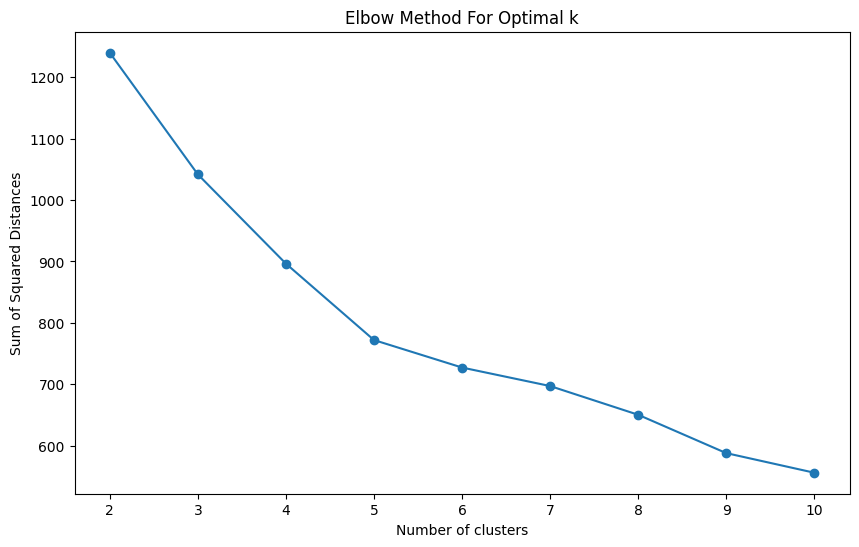

Cluster counts:
 Cluster
3    67
1    50
0    42
2    41
Name: count, dtype: int64
Davies-Bouldin Index: 1.4496363336393272
Average Silhouette Score: 0.2335
Number of clusters formed: 4


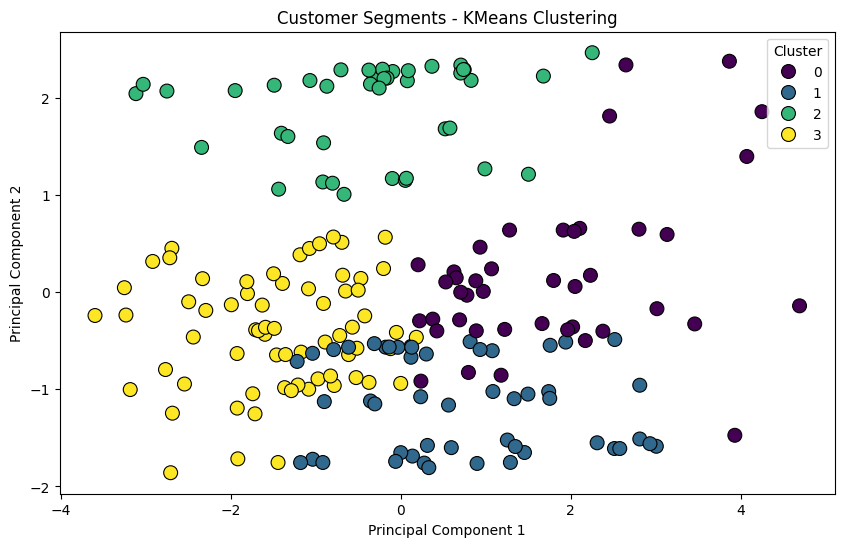

In [12]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Convert date columns to datetime format
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

# Feature engineering:
customers['SignupYear'] = customers['SignupDate'].dt.year
customers['SignupMonth'] = customers['SignupDate'].dt.month


# Aggregating transaction data to get customer-level metrics
customer_transactions = transactions.groupby('CustomerID').agg({
    'TransactionID': 'nunique',
    'TotalValue': 'sum',
    'Quantity': 'sum'
}).reset_index()


# Merging customer profile with transaction metrics
features = pd.merge(customers, customer_transactions, on='CustomerID', how='left')

# Handling missing values: Filling NaNs with 0 (customers with no transactions)
features.fillna({'TransactionID': 0, 'TotalValue': 0, 'Quantity': 0}, inplace=True)

# Encoding categorical variables
features = pd.get_dummies(features, columns=['Region'], drop_first=True)

# Selecting features for clustering
clustering_features = ['SignupYear', 'SignupMonth', 'TransactionID', 'TotalValue', 'Quantity'] + \
                      [col for col in features.columns if col.startswith('Region_')]

# Scaling features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features[clustering_features])

# Elbow Method:
sse = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

# Plotting the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), sse, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squared Distances')
plt.show()

# Based on the Elbow Curve, choose the optimal number of clusters
optimal_clusters = 4

# Applying KMeans clustering
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(scaled_features)


features['Cluster'] = clusters


print("Cluster counts:\n", features['Cluster'].value_counts())

# Calculating Davies-Bouldin Index for evaluation
db_index = davies_bouldin_score(scaled_features, clusters)
print("Davies-Bouldin Index:", db_index)

# Calculating the average Silhouette Score
silhouette_avg = silhouette_score(scaled_features, clusters)
print(f"Average Silhouette Score: {silhouette_avg:.4f}")

# Displaying the number of clusters formed
print(f"Number of clusters formed: {optimal_clusters}")

# Visualizing clusters using the first two principal components
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)
pc_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pc_df['Cluster'] = features['Cluster']

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PC1', y='PC2',
    hue='Cluster',
    palette='viridis',
    data=pc_df,
    s=100, edgecolor='black'
)
plt.title("Customer Segments - KMeans Clustering")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()





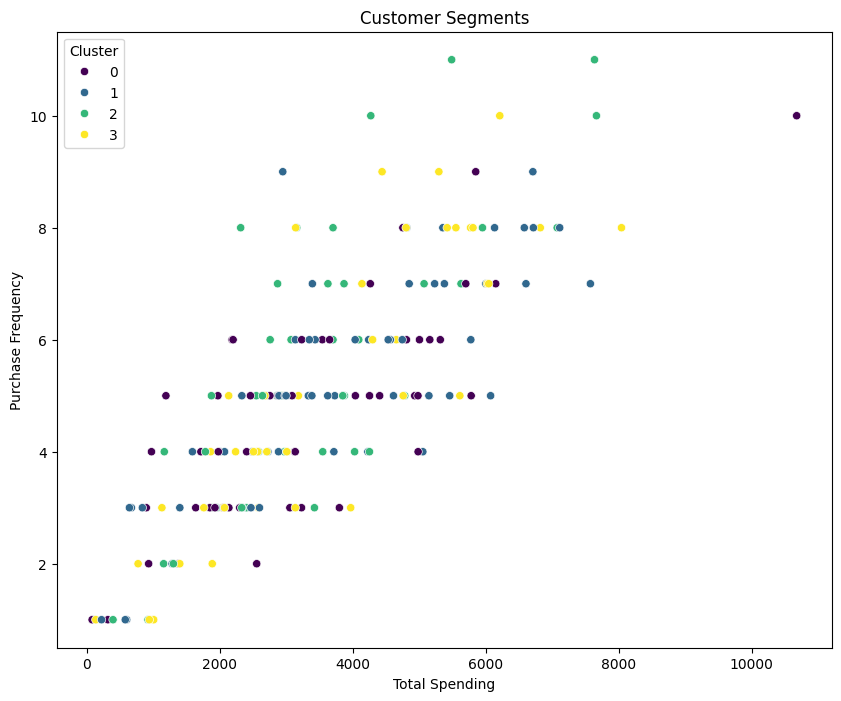

In [15]:
# Visualize clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='TotalSpending', y='PurchaseFrequency', hue='Cluster', data=customer_features, palette='viridis')
plt.title('Customer Segments')
plt.xlabel('Total Spending')
plt.ylabel('Purchase Frequency')
plt.legend(title='Cluster')
plt.show()


Number of clusters formed: 4
Davies-Bouldin Index: 1.4496
Average Silhouette Score: 0.2335


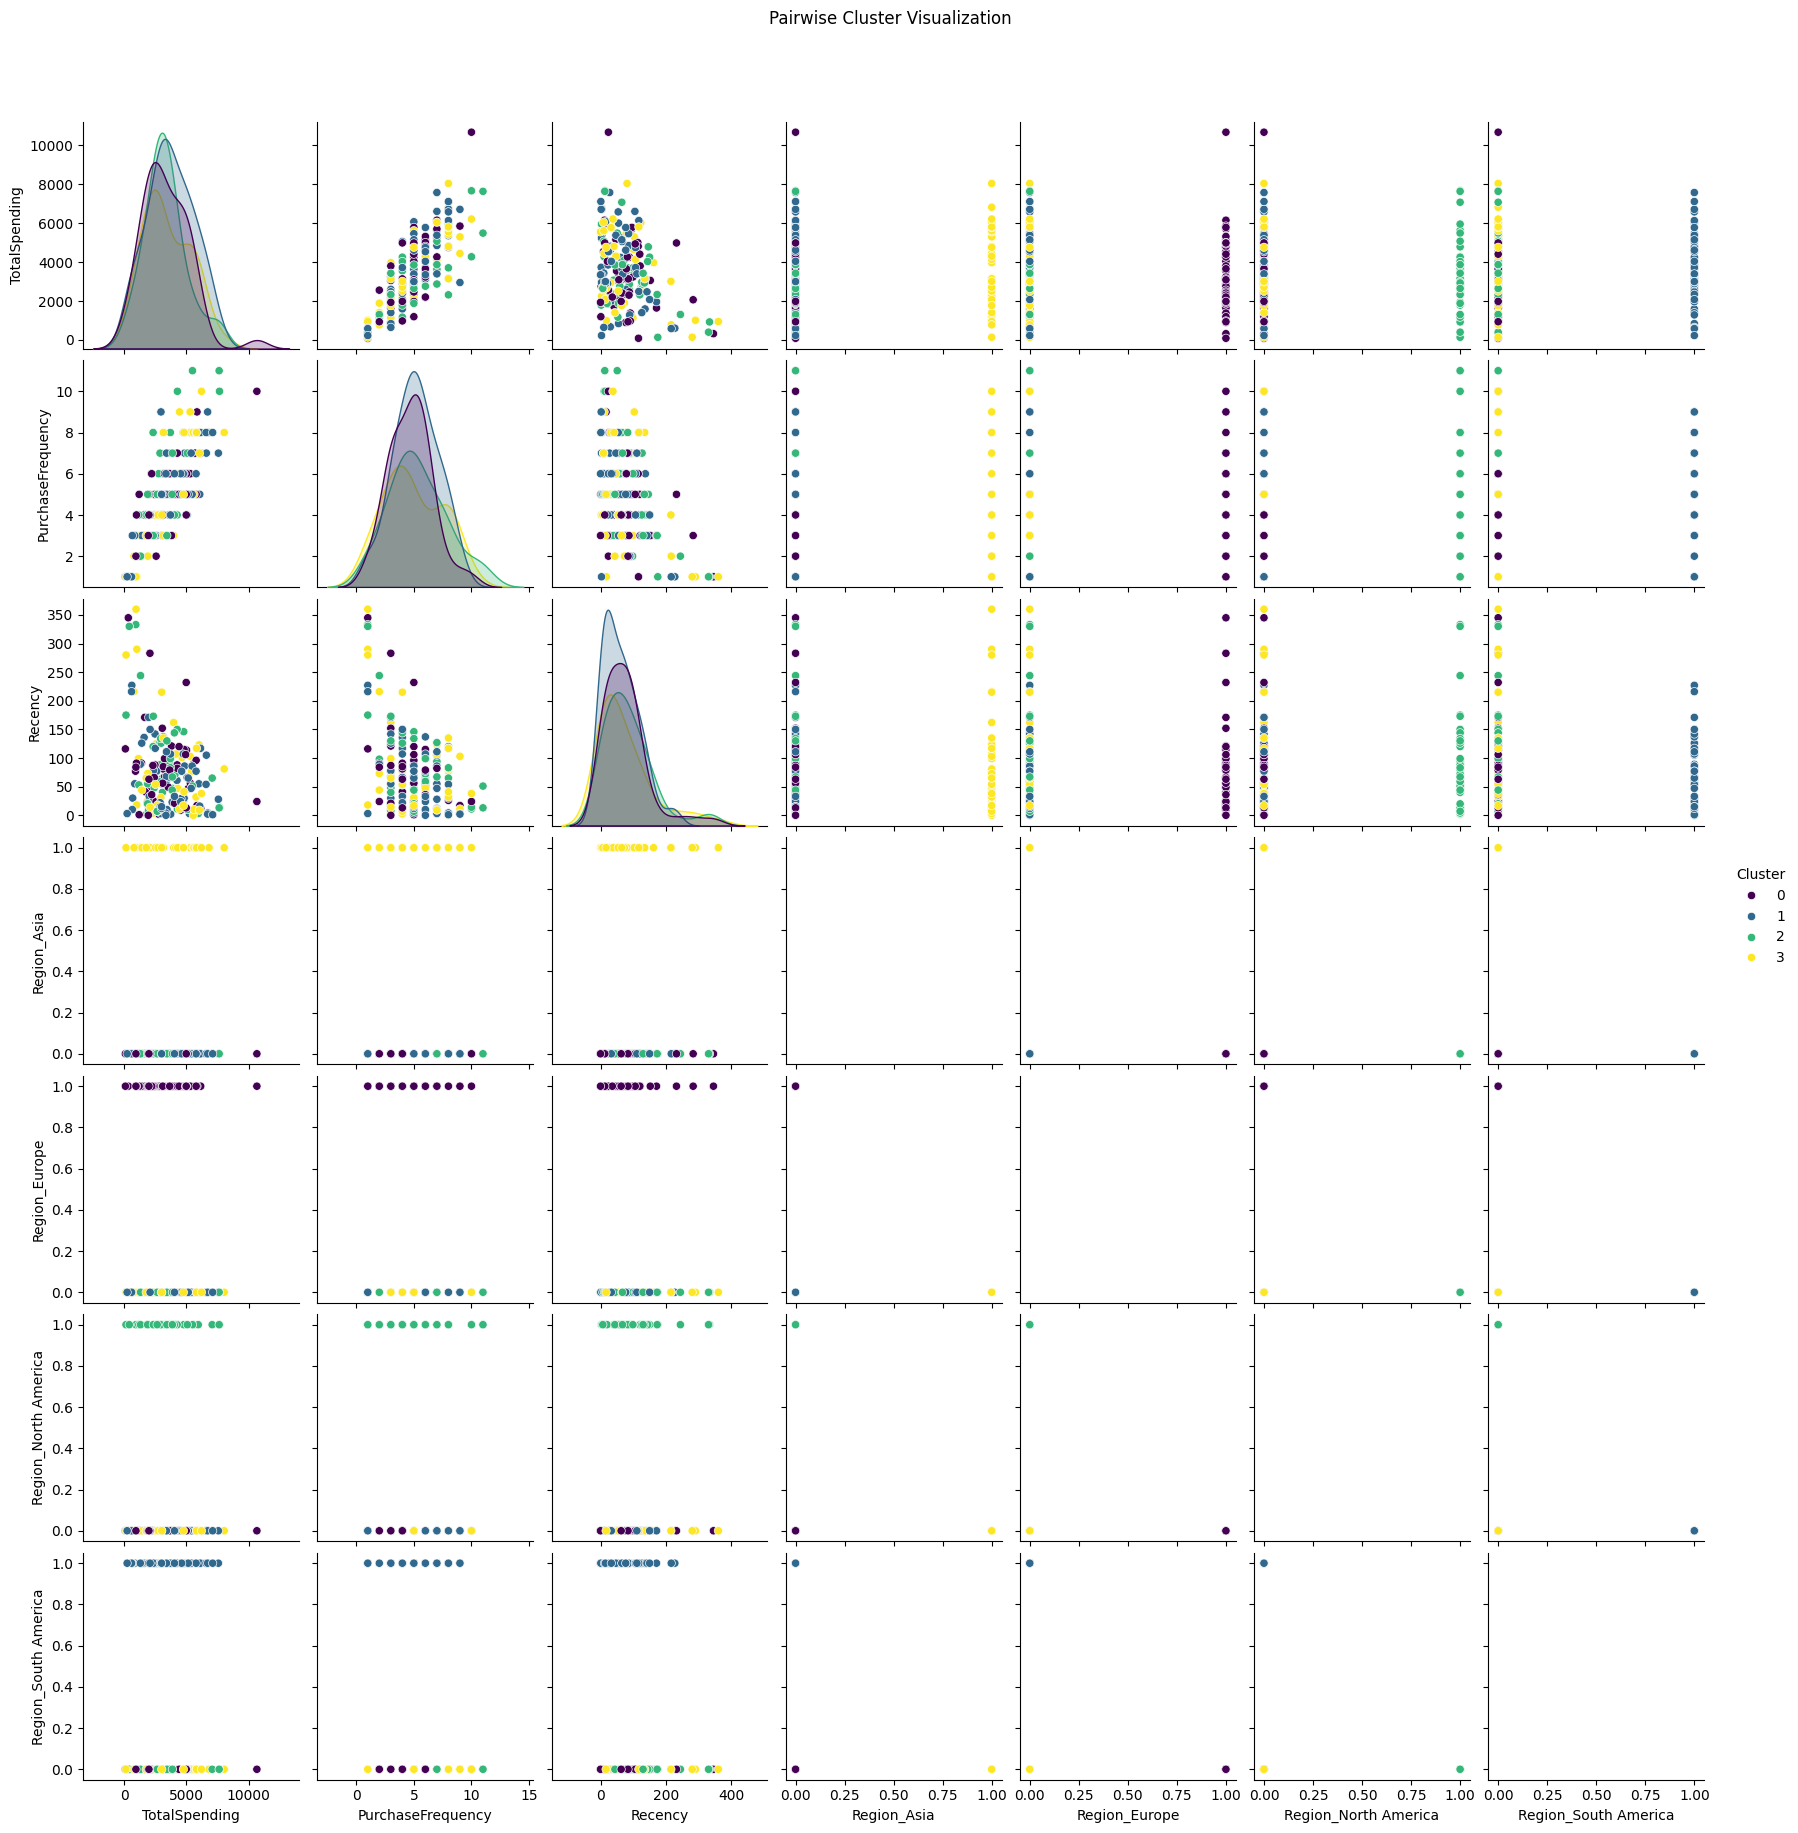

In [14]:
# Calculate Davies-Bouldin Index for evaluation
db_index = davies_bouldin_score(scaled_features, clusters)
silhouette_avg = silhouette_score(scaled_features, clusters)
print(f"Number of clusters formed: {optimal_clusters}")
print(f"Davies-Bouldin Index: {db_index:.4f}")
print(f"Average Silhouette Score: {silhouette_avg:.4f}")

# Visualize pairwise relationships with clusters
sns.pairplot(customer_features, hue='Cluster', palette='viridis', markers='o')
plt.suptitle("Pairwise Cluster Visualization", y=1.05)
plt.show()